In [1]:
import pandas as pd
import numpy as np
#import statsmodels.api as sm
from statsmodels.stats import multitest
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from cycler import cycler
import os
import itertools

In [2]:
def read_data(datapath, codebookpath):
    data = pd.read_csv(datapath, index_col='idno')
    metabolites = data.columns[4:]
    metabolites2exclude = [m for m in metabolites if data.loc[:, m].isna().sum() > len(data) * 0.2]
    data = data.drop(metabolites2exclude, axis=1)
    codebook = pd.read_csv(codebookpath, index_col='metabolite')
    data = data.rename(columns=dict(zip(codebook.index, codebook.MetaboliteName)))
    #data = data.rename(columns=dict(zip(codebook.index, tuple(zip(codebook.AnalyteClass, codebook.MetaboliteName)))))
    try:
        data = data.drop(['material', 'species'], axis=1)
    except KeyError:
        data = data
    A = set(data.columns[2:])
    data = data.drop(A.difference(set(codebook.MetaboliteName)), axis=1)
    return(data)

codebookpath = '../Desktop/Rat_codebook_27_Oct_2022.csv'
datapath = {
    'blood': 'blood_27_Oct_2022',
    'brain': 'brain_27_Oct_2022',
    'blood old': 'old_blood_17_Nov_2022',
    'brain old': 'old_brain_17_Nov_2022',
               }
data = {k: read_data('../Desktop/Rat_' + v + '.csv', codebookpath) for k, v in datapath.items()}


data['brain'].head()

,LIScore,Group,Taurocholic acid,Carnitine,Acetylcarnitine,Propionylcarnitine,Butyrylcarnitine,Valerylcarnitine,Hexenoylcarnitine,Tetradecanoylcarnitine,...,Phosphatidylethanolamine ae 40:1,Phosphatidylethanolamine ae 42:2,Phosphatidylglycerol aa 32:0,Phosphatidylglycerol aa 34:1,Phosphatidylglycerol aa 36:2,Phosphatidylglycerol aa 36:4,Phosphatidylglycerol aa 38:5,Phosphatidylserine aa 34:1,Phosphatidylserine aa 36:1,Phosphatidylserine aa 40:6
idno,,,,,,,,,,,,,,,,,,,,,
105,249,AI,NaN,11.034,1.521,NaN,NaN,0.033825,NaN,0.130,...,1.097,1.350,0.3983,4.147,0.6962,2.943,0.6260,3.963,23.820,95.495
1158,201,AU,0.327,10.904,4.107,0.142000,0.158000,0.068129,0.272,0.167,...,1.234,1.143,0.3517,3.036,0.5238,2.593,0.5484,4.052,NaN,76.815
1172,155,AU,0.378,10.132,4.187,0.072465,0.128000,0.066152,0.102,0.193,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1174,194,AU,0.146,10.024,4.249,0.146000,0.206000,0.132000,0.241,0.360,...,1.189,1.153,0.3748,3.530,0.5092,2.393,0.5173,3.979,34.066,65.968
127,291,AI,NaN,11.611,3.001,NaN,0.088304,0.062654,0.193,0.253,...,1.145,1.413,0.4821,4.428,0.6463,2.665,0.5714,4.618,39.461,93.804


In [51]:
def take1avg(metabolite, group, dataset, data=data):
    df = data[dataset]
    res = df.loc[df.Group == group, metabolite].mean()
    return(res)

def take_all_avgs(group, dataset, data=data):
    l = [take1avg(metabolite, group, dataset, data=data) for metabolite in data[dataset].columns[2:]]
    s = pd.Series(l, index=data[dataset].columns[2:])
    return(s)

def avg_metab_scatter(group, datasetA, datasetB, data=data):
    l = [take_all_avgs(group, dataset, data=data) for dataset in [datasetA, datasetB]]
    df = pd.concat(l, axis=1, join='inner')
    df.columns = [datasetA, datasetB]
    return(df)

def avg_metab_scatter_plot(group, datasetA, datasetB, data=data):
    df = avg_metab_scatter(group, datasetA, datasetB, data=data)
    fig, ax = plt.subplots(figsize=(5, 5))
    #ax.axline((0, 0), slope=1, linewidth=1, linestyle='dotted', color='black')
    ax.scatter(x=datasetA, y=datasetB, marker='.', data=df)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(datasetA)
    ax.set_ylabel(datasetB)
    ax.set_title('Avg metabolite level, ' + group + ' rats')
    return((fig, ax))


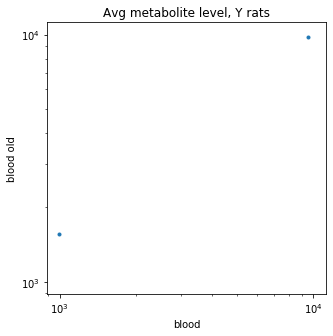

In [50]:

fig, ax = avg_metab_scatter_plot('Y', 'blood', 'blood old')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


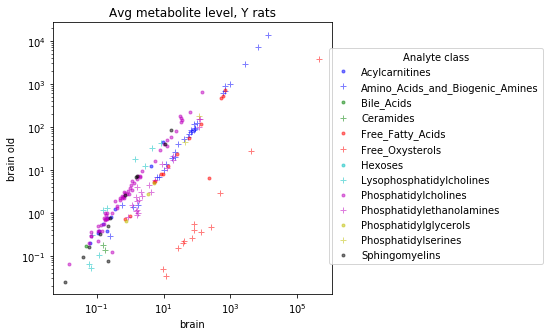

In [39]:
codebook = pd.read_csv(codebookpath, index_col='MetaboliteName')
brain_brainold_Y = avg_metab_scatter('Y', 'brain', 'brain old', data=data)
brain_brainold_Y = pd.concat([brain_brainold_Y, codebook.AnalyteClass], axis=1)
fig, ax = plt.subplots(figsize=(5, 5))
my_cycler = (cycler(color=list('bgrcmyk')) * cycler(marker=['.', '+']))
ax.set_prop_cycle(my_cycler)
ax.set_xlabel('brain')
ax.set_ylabel('brain old')
ax.set_title('Avg metabolite level, Y rats')
#ax.axline((0, 0), slope=1, linewidth=1, linestyle='dotted', color='black')

for aclass in np.unique(brain_brainold_Y.AnalyteClass):
    clsdata = brain_brainold_Y.loc[brain_brainold_Y.AnalyteClass == aclass]
    ax.plot(clsdata['brain'], clsdata['brain old'], label=aclass, alpha=0.5, linestyle = '')
    #ax.scatter(x='brain', y='brain old', data=clsdata, label=aclass)
    ax.set_xscale('log')
    ax.set_yscale('log')

fig.legend(loc='center left', bbox_to_anchor=(0.9, 0.5), title='Analyte class')

In [11]:
diff = brain_brainold_Y.apply(lambda col: 2**abs(np.log2(col['brain'] / col['brain old'])), axis=1)
diff = pd.concat([diff, codebook.AnalyteClass], axis=1)
diff = diff.sort_values(0, ascending=False)
diff.head(20)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,0,AnalyteClass
27-Hydroxycholesterol,562.689585,Free_Oxysterols
7-Dehydrocholesterol,370.256441,Free_Oxysterols
7-alpha-Hydroxycholestenone,350.270430,Free_Oxysterols
"24,25-Epoxycholesterol",266.488774,Free_Oxysterols
"24,25-Dihydrolanosterol",207.390297,Free_Oxysterols
7-beta-Hydroxycholesterol,199.391442,Free_Oxysterols
"5-beta,6-beta-Epoxycholesterol",194.324645,Free_Oxysterols
7-Ketocholesterol,192.854620,Free_Oxysterols
"5-alpha,6-beta-Dihydroxycholestanol (THC)",176.978892,Free_Oxysterols
Lanosterol,175.338750,Free_Oxysterols


### Raw mean metabolites; young, new brain vs. blood
The plot shows points loosely clustered around the line of best fit, implying a slight-to-moderate positive correlation between the new brain and blood raw data for the Y group. The existence of this correlation may be due to the metabolites corresponding to the same rat IDs between datasets, but ultimately the correlation is not strong as data was taken from the different tissue samples (blood and brain).

In [49]:
fig, ax = avg_metab_scatter_plot('Y', 'brain', 'blood')

### Raw mean metabolites; age-impaired, new blood vs. old blood
Points are tightly bunched along the diagonal, implying similar metabolic activity between the new vs. old raw blood data sets. This is consistent with our expectations as the methodology for data collection should be similar between the two, due to the metabolites being measured from the same tissue type (blood) despite being collected from different rat samples. The old blood data set contains more rat samples (15) than the new (10), yet it still exhibits consistency with the new blood data, further validating our methodology. Later, as discussed in this notebook, we use logs of p-values and effect sizes each to observe the replicability between old vs. new data sets.

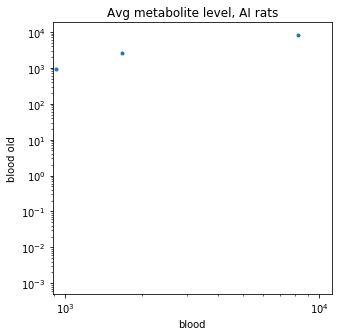

In [14]:
fig, ax = avg_metab_scatter_plot('AI', 'blood', 'blood old')

In [15]:
def extract2groups(metabolite, groupA='AU', groupB='AI', df=data['blood']):
    l = [df.loc[df.Group == g, metabolite].dropna() for g in [groupA, groupB]]
    return(l)

def get_log_p(A, B):
    val = - np.log10(stats.ttest_ind(A, B)[1])
    return(val)

def get_effect_size(A, B):
    '''
    The effect size x is B relative to A, so if A > B => x < 0
    '''
    #val = B.mean() - A.mean() # the original definition; does not normalize effect size!
    OR = B.mean() / A.mean()
    log2OR = np.log2(OR)
    return(log2OR)

def get_both(metabolite, groupA='AU', groupB='AI', df=data['blood']):
    A, B = extract2groups(metabolite, groupA, groupB, df)
    log_p = get_log_p(A, B)
    fx_size = get_effect_size(A, B)
    return((fx_size, log_p))

def get_both_all(groupA='AU', groupB='AI', df=data['blood']):
     metabolites = df.columns[2:]
     l = [get_both(m, groupA, groupB, df) for m in metabolites]
     fx_sizes = [x[0] for x in l]
     log_ps = [x[1] for x in l]
     return((fx_sizes, log_ps))

In [16]:
comparisons = {
    'AI vs. AU': ['AU', 'AI'],
    'AI vs. Y': ['Y', 'AI'],
    'AU vs. Y': ['Y', 'AU'],
              }
results = {d: {k: get_both_all(*v, df=data[d]) for k, v in comparisons.items()} for d in data.keys()}



In [17]:
def writeResults(dataset='brain', comparison='AI vs. AU', alpha=0.05, method='fdr_bh', data=data, results=results):
    dat = data[dataset]
    codebook = pd.read_csv(codebookpath, index_col='MetaboliteName')
    metabolites = dat.columns[2:]
    metab_class = codebook.loc[metabolites, 'AnalyteClass']
    res = results[dataset]
    t = res[comparison]
    direction = ['Increase' if x>0 else 'Decrease' for x in t[0]]
    pvals = 10 ** (-np.array(t[1]))
    reject, pvals_corrected, alphacSidak, alphacBonf = multitest.multipletests(pvals, alpha=alpha, method=method)
    df = pd.DataFrame({'Dataset':dataset, 'Comparison': comparison,
                       'Analyte class': metab_class, 'Metabolite': metabolites,
                       'Effect size':t[0],'"- log p"':t[1], 'p': pvals,
                       r'Corrected p': pvals_corrected,
                       r'Reject H0': reject,
                       r'Bonferroni alpha': alphacBonf,
                       'Direction of change': direction})
    df = df.sort_values('Effect size')
    df = df.sort_values('p')
    df['Rank'] = np.arange(len(df)) + 1
    return(df)



In [19]:
ll = [[writeResults(dataset=d, comparison=c) for c in comparisons.keys()] for d in data.keys()]
l = itertools.chain(*ll)
summary = pd.concat(l)
summary.to_csv('../Desktop/summary.csv')
summary

,Dataset,Comparison,Analyte class,Metabolite,Effect size,"""- log p""",p,Corrected p,Reject H0,Bonferroni alpha,Direction of change,Rank
Phosphatidylcholine aa C40:5,blood,AI vs. AU,Phosphatidylcholines,Phosphatidylcholine aa C40:5,-0.656900,1.831301,0.014747,0.758869,False,0.000189,Decrease,1
Linolenic acid,blood,AI vs. AU,Free_Fatty_Acids,Linolenic acid,-0.442021,1.707973,0.019590,0.758869,False,0.000189,Decrease,2
"5-beta,6-beta-Epoxycholesterol",blood,AI vs. AU,Free_Oxysterols,"5-beta,6-beta-Epoxycholesterol",-1.162864,1.677275,0.021024,0.758869,False,0.000189,Decrease,3
Spermine,blood,AI vs. AU,Amino_Acids_and_Biogenic_Amines,Spermine,0.550324,1.646695,0.022558,0.758869,False,0.000189,Increase,4
trans-4-Hydroxyproline,blood,AI vs. AU,Amino_Acids_and_Biogenic_Amines,trans-4-Hydroxyproline,0.969954,1.588279,0.025806,0.758869,False,0.000189,Increase,5
"5-alpha,6-alpha-Epoxycholesterol",blood,AI vs. AU,Free_Oxysterols,"5-alpha,6-alpha-Epoxycholesterol",-1.300067,1.496875,0.031851,0.758869,False,0.000189,Decrease,6
alpha-Aminoadipic acid,blood,AI vs. AU,Amino_Acids_and_Biogenic_Amines,alpha-Aminoadipic acid,0.461159,1.455831,0.035008,0.758869,False,0.000189,Increase,7
Phosphatidylcholine aa C40:4,blood,AI vs. AU,Phosphatidylcholines,Phosphatidylcholine aa C40:4,-0.451711,1.443368,0.036027,0.758869,False,0.000189,Decrease,8
Glycine,blood,AI vs. AU,Amino_Acids_and_Biogenic_Amines,Glycine,0.392926,1.374221,0.042245,0.758869,False,0.000189,Increase,9
2-Hydroxyacyldihydroceramide C16:0,blood,AI vs. AU,Ceramides,2-Hydroxyacyldihydroceramide C16:0,-0.403521,1.335998,0.046132,0.758869,False,0.000189,Decrease,10


In [47]:
def volcano_subplot(axi, df, comparison, dataset, classes, dolabel=False):
    my_cycler = (cycler(color=list('bgrcmyk')) * cycler(marker=['.', '+']))
    axi.set_prop_cycle(my_cycler)
    bonf_alpha = -np.log10(df['Bonferroni alpha'].to_list()[0])
    axi.axhline(y=bonf_alpha, linestyle='dotted', color='black', linewidth=1)
    for k, cls in enumerate(classes):
        clsdf = df.loc[(df['Analyte class'] == cls) & (df.Dataset == dataset)]
        label = cls if dolabel else None
        axi.plot(clsdf['Effect size'], clsdf['"- log p"'], label=label, alpha=0.5, linestyle = '')
        #axi.scatter(x=clsdf['Effect size'], y=clsdf['"- log p"'], label=cls, alpha=0.5) # this does not work with cycler & marker 
        axi.set_title(comparison, fontsize=14)
        axi.set_ylabel(dataset, fontsize=14)
    return(axi)

def my_volcano(summary, swapij=False, figsize=(15, 20)):
    comparisons = np.unique(summary.Comparison)
    datasets = np.unique(summary.Dataset)
    classes = np.unique(summary['Analyte class'])
    fig, ax = plt.subplots(len(datasets), len(comparisons), figsize=figsize, sharey=True, sharex=True, squeeze=False)
    for i, dataset in enumerate(datasets):
        for j, comparison in enumerate(comparisons):
            df = summary.loc[(summary.Dataset == dataset) & (summary.Comparison == comparison)]
            axi = ax[j, i] if swapij else ax[i, j]
            dolabel = (i == 0) and (j == 0)
            volcano_subplot(axi, df, comparison, dataset, classes, dolabel=dolabel)
    #fig.set_xlabel(r'$\log_{2}$ fold change', fontsize=16)
    #fig.supylabel(r'$- \log_{10} p$', fontsize=16)
    fig.legend(loc='center left', bbox_to_anchor=(0.9, 0.5), title='Analyte class')
    return((fig, ax))

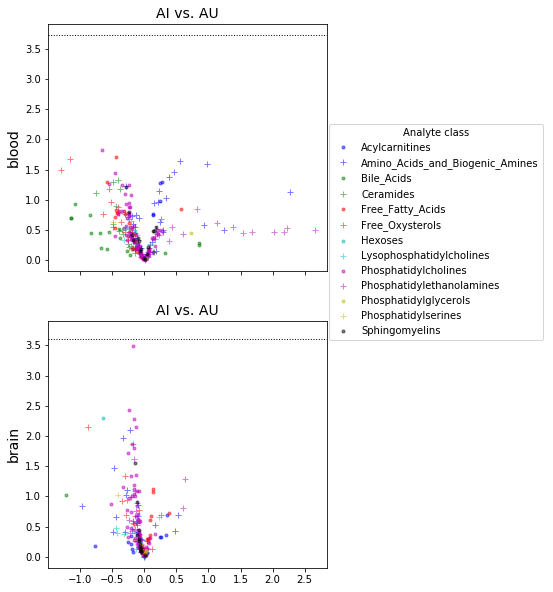

In [48]:
fig, ax = my_volcano(summary.loc[(summary.Comparison == 'AI vs. AU') & summary.Dataset.isin(['blood', 'brain'])], figsize=(5, 10))


### Replication of findings between data sets

In [29]:
def dataset_scatter(datasetA, datasetB, comparison, ax, statistic='"- log p"', summary=summary, rank_thrs=20):
    A, B = [summary.loc[(summary.Dataset == d) & (summary.Comparison == comparison), [statistic, 'Rank']] for d in [datasetA, datasetB]]
    df = pd.concat([A, B], axis=1, join='inner')
    df.columns = [datasetA, 'Rank ' + datasetA, datasetB, 'Rank ' + datasetB]
    df['color'] = None
    df.loc[(df['Rank ' + datasetA] <= rank_thrs) & (df['Rank ' + datasetB] <= rank_thrs), 'color'] = 'orange'
    df.loc[(df['Rank ' + datasetA] <= rank_thrs) & (df['Rank ' + datasetB] > rank_thrs), 'color'] = 'magenta'
    df.loc[(df['Rank ' + datasetA] > rank_thrs) & (df['Rank ' + datasetB] <= rank_thrs), 'color'] = 'blue'
    df.loc[(df['Rank ' + datasetA] > rank_thrs) & (df['Rank ' + datasetB] > rank_thrs), 'color'] = 'lightgray'
    #return((thrsA, thrsB))
    ax.scatter(x=datasetA, y=datasetB, data=df, marker='.', color=df.color)
    color = 'black'
    linestyle = 'dotted'
    linewidth = 1
    if statistic == '"- log p"':
        ax.axvline(df.loc[df['Rank ' + datasetA] == rank_thrs, datasetA].to_list()[0], color=color, linestyle=linestyle, linewidth=linewidth)
        ax.axhline(df.loc[df['Rank ' + datasetB] == rank_thrs, datasetB].to_list()[0], color=color, linestyle=linestyle, linewidth=linewidth)
    #if statistic == 'Effect size':
        #ax.axline((0, 0), slope=1, color=color, linestyle=linestyle, linewidth=linewidth)
    ax.set_xlabel(datasetA)
    ax.set_ylabel(datasetB)
    ax.set_title(statistic + ', ' + comparison)
    return(ax)

def datset_2scatters(datasetA, datasetB, comparison, suptitle=''):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(suptitle)
    for statistic, axi in zip(['"- log p"', 'Effect size'], ax):
        dataset_scatter(datasetA=datasetA, datasetB=datasetB, comparison=comparison, statistic=statistic, ax=axi)
    return((fig, ax))


### AI vs. AU; new brain vs. old brain

Two plots are presented here: one containing -log(p) data points, and the other comparing effect sizes.

The top 20 metabolites (by p-value) for new brain data are observed to the right of the vertical dotted line (x = 1.2), colored magenta and yellow. The points above the horizontal line (y = 1.05) represent the top 20 metabolites in the old brain data set (colored blue and yellow). The metabolites that are in the top 20 of both new and old brain data are colored orange, and are found in the top right quadrant. The replication (according to the top 20 criteria) is poor; only one of the 20 metabolites replicated in both new and old brain data.

There are more points covering a wider range of values for the top 20 of new brain data only (quadrant IV) than there are for the top 20 of old brain data only (quadrant II), despite the old brain set containing more data.

Effect sizes (right) are, as a whole, more closely grouped together than the -log(p) values. With the exception of a few points, most data points are assembled near the center-right of the plot, being mostly non-negative values. This small but substantial positive correlation implies that slight, but meaningful, replication occurred.

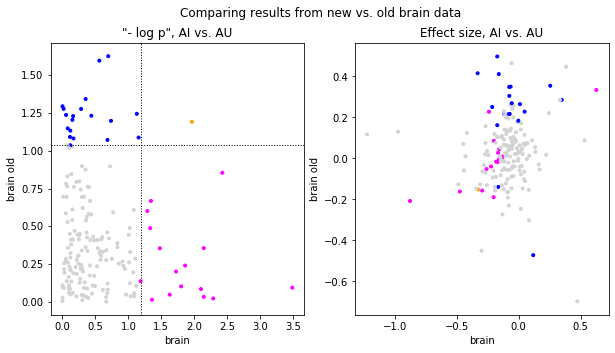

In [30]:
fig, ax = datset_2scatters('brain', 'brain old', comparison='AI vs. AU', suptitle='Comparing results from new vs. old brain data')


### AI vs. Y; new brain vs. old brain

A similar, but wider, distribution is obsrved in both the -log(p) (left) and effect size (right) plots compared to the AI vs. AU plots for the same brain data comparison. We observe that more metabolites (5 compared to 1 for AI vs. AU) in the top 20 of both new and old brain data are replicated. The correlation is likewise stronger for the effect sizes plot (right). As similarly observed in the volcano plots, both the -log(p) and effect size values are greater than those of the AI vs. AU plot. Thus, the greater effects in the AI vs. Y comparison result in better replication across the datasets.

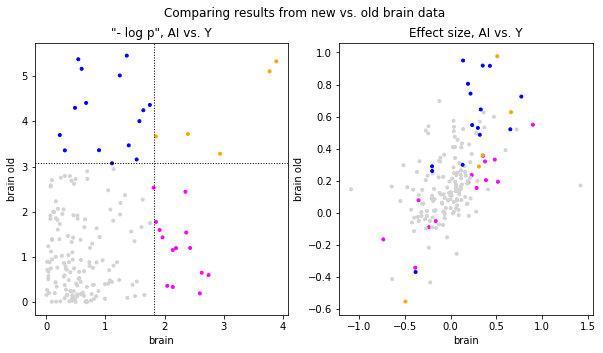

In [31]:
fig, ax = datset_2scatters('brain', 'brain old', comparison='AI vs. Y', suptitle='Comparing results from new vs. old brain data')


### AU vs. Y; new brain vs. old brain


(Similar observations and conclusions as AI vs. Y).

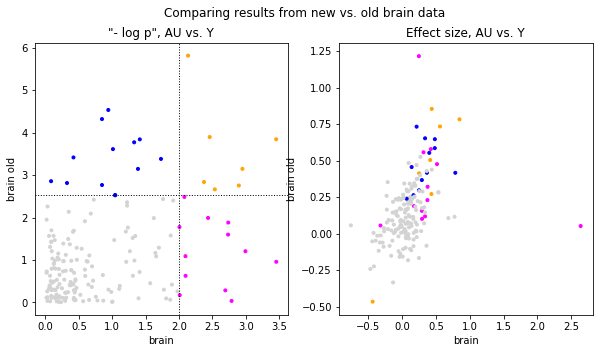

In [32]:
fig, ax = datset_2scatters('brain', 'brain old', comparison='AU vs. Y', suptitle='Comparing results from new vs. old brain data')


## Blood data comparisons

Overall, the replication for the blood vs. the blood old data sets is better than those of the brain vs. brain old data due to the latter exhibiting generally weaker effects overall.

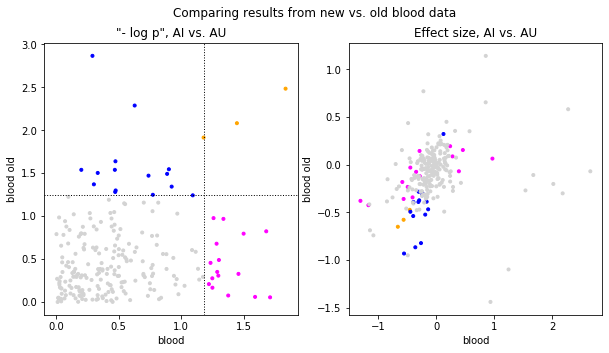

In [33]:
fig, ax = datset_2scatters('blood', 'blood old', comparison='AI vs. AU', suptitle='Comparing results from new vs. old blood data')

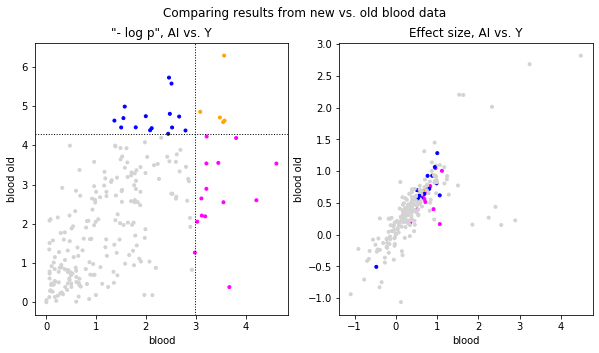

In [34]:
fig, ax = datset_2scatters('blood', 'blood old', comparison='AI vs. Y', suptitle='Comparing results from new vs. old blood data')

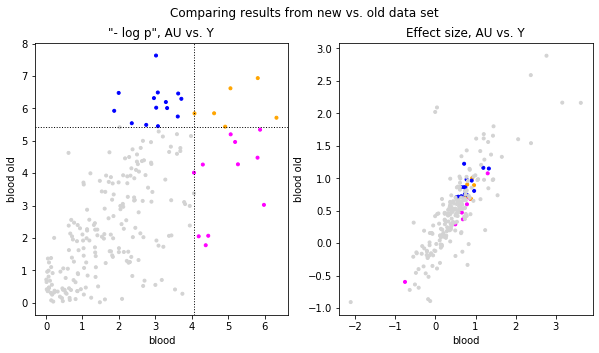

In [35]:
fig, ax = datset_2scatters('blood', 'blood old', comparison='AU vs. Y', suptitle='Comparing results from new vs. old data set')


## Brain vs. blood

The goal was to observe how the results differ between brain vs. blood tissue data. 

### AI vs. Y
We observe a relatively weak correlation between brain vs. blood data, compared to results of same-tissue comparisons. The different results are likely due to the tissue type rather than the replication itself, and further due to a number of possibilities: individual differences in envirnment, genomics, blood-brain barrier transport across rats, etc. We can infer that the transport mechanism modifies the results. 

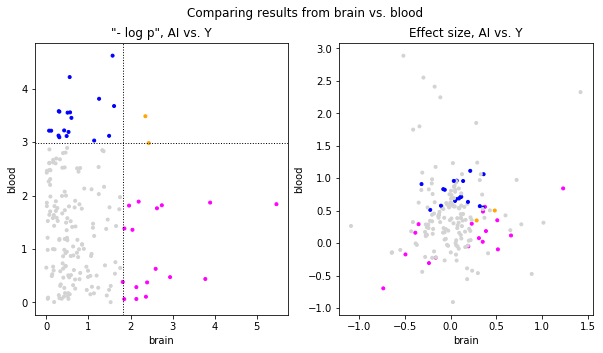

In [36]:
fig, ax = datset_2scatters('brain', 'blood', comparison='AI vs. Y', suptitle='Comparing results from brain vs. blood')
